<h1 style="text-align:center"> Doc2vec on clients reviews for places classification  </h1>

## Introduction 


The goal of the following study is to explore the potential of doc2vec algorithm applied on customers reviews in the task of places classification. 

## Process  

<p>The algorithmic process that we are aiming to implement contains the following steps:
<p>   .  </p>
<p>1- Read data from places scrapped CSV file and select places that have french reviews (at least one french review).
<p>2- Group the reviews by places and create 1 document per place containing all of its french reviews. 
<p>3- Training a Doc2vec model to generate 1 vector per document
<p>4- Study similarities detected and analyse the patterns.
<p>5- Based on the previous analysis create generic place classes and Label the data. 
<p>9- Prepare data for classification : mapping Vectors to place Labels 
<p>10- Train a classifier to perform the mapping 
<p>11- Analyse the overall accuracy and intra-classes accuracy and optimize the model and the data.


### Data importing 

In [148]:
# Import all the required libraries 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix


In [6]:
# Import the CSV file (provided in the directory), change the path if the csv file is not in the same folder as your notebook

#df_pl = pd.read_csv("C:\\Users\\Lenovo_T530\\Desktop\\Project\\Reviews\\cotedazur_places_full_2018-11-15.csv",sep=",")

df_pl = pd.read_csv("cotedazur_places_full_2018-11-15.csv",sep=",")

df_pl.head(5)

#Each row corresponds to a different review. So the same place is repeated in this table the number of reviews it has.
    

C:\Users\Lenovo_T530\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (2,4,11,15,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,venue,title,description,lang,telephone,email,url,businessType,categoryName,latitude,...,streetAddress,city,img,seeAlso,publisher,sameAs,topoImportance,rating,reviewLang,review
0,http://data.linkedevents.org/location/a8a1f925...,McDonald's,NaN,NaN,3.34946e+10,NaN,http://www.restaurants.mcdonalds.fr/mcdonalds-...,http://data.linkedevents.org/kos/foursquare/fa...,Fast Food Restaurant,43.2616,...,"RN 559 (Quartier Joffret), 83580 GASSIN, France",GASSIN,https://igx.4sqi.net/img/general/720x431/24260...,NaN,http://www.foursquare.com,https://www.foursquare.com/v/mcdonalds/4c62f10...,NaN,3.0,en,Use the easy order system. Very fast!
1,http://data.linkedevents.org/location/a8a1f925...,McDonald's,NaN,NaN,3.34946e+10,NaN,http://www.restaurants.mcdonalds.fr/mcdonalds-...,http://data.linkedevents.org/kos/foursquare/fa...,Fast Food Restaurant,43.2616,...,"RN 559 (Quartier Joffret), 83580 GASSIN, France",GASSIN,https://igx.4sqi.net/img/general/720x431/24260...,NaN,http://www.foursquare.com,https://www.foursquare.com/v/mcdonalds/4c62f10...,NaN,3.0,fr,Les employés ne connaissent pas (littéralement...
2,http://data.linkedevents.org/location/a8a1f925...,McDonald's,NaN,NaN,3.34946e+10,NaN,http://www.restaurants.mcdonalds.fr/mcdonalds-...,http://data.linkedevents.org/kos/foursquare/fa...,Fast Food Restaurant,43.2616,...,"RN 559 (Quartier Joffret), 83580 GASSIN, France",GASSIN,https://igx.4sqi.net/img/general/720x431/24260...,NaN,http://www.foursquare.com,https://www.foursquare.com/v/mcdonalds/4c62f10...,NaN,3.0,fr,"Super rapide, relativement propre mais personn..."
3,http://data.linkedevents.org/location/a8a1f925...,McDonald's,NaN,NaN,3.34946e+10,NaN,http://www.restaurants.mcdonalds.fr/mcdonalds-...,http://data.linkedevents.org/kos/foursquare/fa...,Fast Food Restaurant,43.2616,...,"RN 559 (Quartier Joffret), 83580 GASSIN, France",GASSIN,https://igx.4sqi.net/img/general/720x431/24260...,NaN,http://www.foursquare.com,https://www.foursquare.com/v/mcdonalds/4c62f10...,NaN,3.0,en,Mac shittt
4,http://data.linkedevents.org/location/194949f0...,Barbarac,NaN,NaN,3.3495e+10,NaN,http://barbarac.fr,http://data.linkedevents.org/kos/foursquare/ic...,Ice Cream Shop,43.2714,...,"2 rue Général Allard, 83990 Saint-Tropez, France",Saint-Tropez,https://igx.4sqi.net/img/general/537x720/sq9hS...,NaN,http://www.foursquare.com,https://www.foursquare.com/v/barbarac/4bfaed7a...,NaN,4.5,it,Gelato fantastico. Il migliore di St. Tropez


In [7]:
# Selecting only rows that hold a french review  

df_pl_fr_old = df_pl[df_pl.reviewLang == "fr"]

# Dropping empty or irrelevant columns 

df_pl_fr = df_pl_fr_old.drop(['categoryName','description','lang','email',
                              'businessType','city','seeAlso','topoImportance'],1)
# Drop duplicates (if any)

df_pl_fr = df_pl_fr.drop_duplicates()

# Update the indexes of the new table 

df_pl_fr.index=range(len(df_pl_fr))

# print the  new table  

df_pl_fr.head(5)


,venue,title,telephone,url,latitude,longitude,postalCode,streetAddress,img,publisher,sameAs,rating,reviewLang,review
0,http://data.linkedevents.org/location/a8a1f925...,McDonald's,3.34946e+10,http://www.restaurants.mcdonalds.fr/mcdonalds-...,43.2616,6.57665,83580,"RN 559 (Quartier Joffret), 83580 GASSIN, France",https://igx.4sqi.net/img/general/720x431/24260...,http://www.foursquare.com,https://www.foursquare.com/v/mcdonalds/4c62f10...,3.0,fr,Les employés ne connaissent pas (littéralement...
1,http://data.linkedevents.org/location/a8a1f925...,McDonald's,3.34946e+10,http://www.restaurants.mcdonalds.fr/mcdonalds-...,43.2616,6.57665,83580,"RN 559 (Quartier Joffret), 83580 GASSIN, France",https://igx.4sqi.net/img/general/720x431/24260...,http://www.foursquare.com,https://www.foursquare.com/v/mcdonalds/4c62f10...,3.0,fr,"Super rapide, relativement propre mais personn..."
2,http://data.linkedevents.org/location/194949f0...,Barbarac,3.3495e+10,http://barbarac.fr,43.2714,6.63842,83990,"2 rue Général Allard, 83990 Saint-Tropez, France",https://igx.4sqi.net/img/general/537x720/sq9hS...,http://www.foursquare.com,https://www.foursquare.com/v/barbarac/4bfaed7a...,4.5,fr,Assurément les meilleures glaces de St Tropez ...
3,http://data.linkedevents.org/location/194949f0...,Barbarac,3.3495e+10,http://barbarac.fr,43.2714,6.63842,83990,"2 rue Général Allard, 83990 Saint-Tropez, France",https://igx.4sqi.net/img/general/537x720/sq9hS...,http://www.foursquare.com,https://www.foursquare.com/v/barbarac/4bfaed7a...,4.5,fr,La glace au yaourt ... Un délice !!
4,http://data.linkedevents.org/location/194949f0...,Barbarac,3.3495e+10,http://barbarac.fr,43.2714,6.63842,83990,"2 rue Général Allard, 83990 Saint-Tropez, France",https://igx.4sqi.net/img/general/537x720/sq9hS...,http://www.foursquare.com,https://www.foursquare.com/v/barbarac/4bfaed7a...,4.5,fr,Glace au yaourt sans hésiter!


## Grouping the reviews

In [8]:
## Create a list holding all the places names we have 

placeNames = list(df_pl_fr.title.unique())

print("First Places names: ", placeNames[0:4])

First Places names:  ["McDonald's", 'Barbarac', 'Café de Paris', 'La Place de Mougins']


In [12]:
## Selecting the reviews gathered for a specific place

mcdoReviews = df_pl_fr[df_pl_fr['title'] == placeNames[0]]['review']

print("McDonald's reviews:\n\n", mcdoReviews)

McDonald's reviews:

 0       Les employés ne connaissent pas (littéralement...
1       Super rapide, relativement propre mais personn...
8                                Trés bon! Je recommende!
9       Heureusement qu'on paye pas le sourire des emp...
10      très bruyant à midi en semaine à cause du coll...
20      Service impéccable et accueil chaleureux comme...
21      Service rapide, nourriture sans saveur bourrée...
25      A 8,20€ le Maxi BestOf Chicken Mythic Bacon es...
27      Ne pas être pressé (comble pour de la restaura...
28      Un véritable effort a été fait pour aménager d...
29      Commander aux bornes de l'étage ! Y'a moins de...
45      Attente longue due à un personnel incompétent ...
46              oubliez le "p'tit oriental": PAS TERRIBLE
56      Equipe sympathique, face à la mer. Le McDo idé...
104     Pensez a mettre les sauces potatoes et ketchup...
105     Plus de gentillesse et de respect envers la cl...
110     Restaurant assez sympa quand il fait beau 

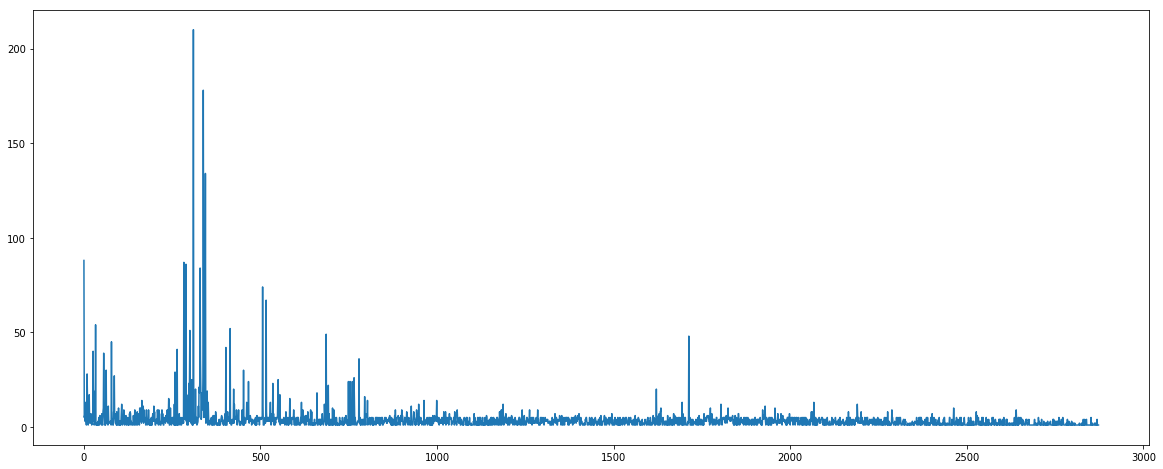

In [41]:
## Get the distribution of number of reviews 
counts = []

for place in placeNames: 
    counts.append(df_pl_fr[df_pl_fr['title'] == place]['review'].count())
    
plt.figure(figsize = (20,8))
plt.plot(counts)

In [45]:
print("The Maximum Reviews number: ", max(counts), ' Place: ',placeNames[np.argmax(counts)])
print("The Minimum Reviews number: ", min(counts), ' Place: ',placeNames[np.argmin(counts)])
print("The Average Reviews number: ", round(np.mean(counts)))
print("The Median  Reviews number: ", np.median(counts))


The Maximum Reviews number:  210  Place:  Casino Shop
The Minimum Reviews number:  1  Place:  Centre commercial Carrefour Antibes
The Average Reviews number:  4.0
The Median  Reviews number:  3.0


## Constructing doc2vec training data

<div class="alert alert-warning">
We construct 1 document per place. Each document will contain all the gathered reviews for the place in question
</div>

In [113]:
training_data=[]
for j in range(len(placeNames)) : 
    new_file = str()
    for i in list(df_pl_fr[df_pl_fr['title'] == placeNames[j]]['review']) : 
        new_file+=(i+' ')
    training_data.append(new_file)

<div class="alert alert-warning">
Here is a part of the content of the first document: 
</div>

In [51]:
print(training_data[0][0:1000])

Les employés ne connaissent pas (littéralement) les réductions étudiantes Super rapide, relativement propre mais personnel de salle un peu intrusif et manquant cruellement de tact. Trés bon! Je recommende! Heureusement qu'on paye pas le sourire des employé !! très bruyant à midi en semaine à cause du collège/lycée à proximité. Service impéccable et accueil chaleureux comme on en voit très rarement dans un macdo. Bravo ! Service rapide, nourriture sans saveur bourrée de sauce, cher. A 8,20€ le Maxi BestOf Chicken Mythic Bacon est une belle escroquerie! Ne pas être pressé (comble pour de la restauration Rapide),  bien vérifier sa commande!  Amabilité : sans commentaire!  Lol. Un véritable effort a été fait pour aménager de façon chaleureuse ce point de vente et mettre en valeur le savoir-faire de McDonald's. Service à table : c'est novateur mais inutile à mes yeux. Commander aux bornes de l'étage ! Y'a moins de monde. Attente longue due à un personnel incompétent incapable de connaitre s

<div class="alert alert-warning">
Let's train a doc2vec algorithm on the training data
</div>

In [114]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(training_data)]

In [131]:
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

#model.save("d4v.model")
#print("Model Saved")

C:\Users\Lenovo_T530\Anaconda3\lib\site-packages\gensim\models\doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


iteration 0


C:\Users\Lenovo_T530\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration 77
iteratio

In [ ]:
# Save your model 

model.save("d4v.model")
print("Model Saved")

In [ ]:
## To load the model

model= Doc2Vec.load("d4v.model")

In [116]:
# To test the model, we can use most_similar in build function (takes tags as input and return tags )
similar_doc = model.docvecs.most_similar(0)
print(similar_doc)

[('868', 0.857935905456543), ('1671', 0.8571186065673828), ('1959', 0.8526476621627808), ('2806', 0.8505672812461853), ('1875', 0.8431761264801025), ('1292', 0.8401811122894287), ('109', 0.8312878012657166), ('2231', 0.8299049139022827), ('639', 0.8235914707183838), ('1835', 0.8165018558502197)]


C:\Users\Lenovo_T530\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [117]:
# A function to test the model that takes names as input and return names

def determine_similar(placeName = 'Barbarac') :
    results = []
    categories = [] 
    if placeName in placeNames : 
        tag = placeNames.index(placeName)
        similar_doc = model.docvecs.most_similar(tag)
        for el in similar_doc:
            results.append(placeNames[int(el[0])])
            categories.append(df_pl[df_pl['title'] == placeNames[int(el[0])]]['categoryName'])
    return results

In [118]:
determine_similar(placeName = 'Barbarac')

C:\Users\Lenovo_T530\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


['La Bella Trattoria',
 'Bar Restaurant du Port',
 'Papilla',
 'La Salle A Manger',
 'Le San Remo',
 'The Frenchy Burger',
 'La Guérite',
 'Restaurant Délicatessen',
 'Pizzeria Bruno',
 'La Pizza']

In [132]:
determine_similar(placeName = "McDonald's")

C:\Users\Lenovo_T530\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


['Blue Bar',
 "L'escapade",
 'Phnom Penh',
 'Plage des Trois Pins',
 'Pizzeria de la Rade',
 'Yummy Pizza',
 'Pizza Pili',
 "L'Endroit",
 'La Mama',
 'Le Comptoir']

In [120]:
determine_similar(placeName = "Hôtel Le Chastellan")

C:\Users\Lenovo_T530\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


['Auberge Quintessence',
 'Hôtel Courbet',
 'Hotel Savoy',
 'Hôtel Hoche',
 'Hôtel Les Amandiers',
 "Hôtel Gray d'Albion",
 'Toile Blanche',
 'Eglise Saint Jean-Baptiste',
 'Le Relais Gourmand',
 'Domaine des Bruguières']

In [121]:
determine_similar(placeName = "Hôtel Courbet")

C:\Users\Lenovo_T530\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


['Hotel Savoy',
 'Hôtel Le Chastellan',
 "Le Chalet d'Auron",
 'Mixtape',
 'Auberge Quintessence',
 'Diffazur Piscines',
 'Le Relais Gourmand',
 'Une Maison à Saint-Paul de Vence',
 "L'atelier Joseph",
 'Au Paradis des Campeurs']

In [122]:
determine_similar(placeName = "Camping Clos Rose Marie")

C:\Users\Lenovo_T530\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


['Artcamping Plateau des Chasses',
 'Hôtel Méditerranée',
 'Camping Le Grand Calme',
 'Café du Commerce',
 'Studio Bord de Mer à Cannes',
 'Camping Azur Rivage',
 "Le Chalet d'Auron",
 "Camping Sandaya Riviera d'Azur",
 'Hotel Savoy',
 'Au Paradis des Campeurs']

In [123]:
determine_similar(placeName = "Picard")

C:\Users\Lenovo_T530\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


['Monoprix',
 'Naturalia',
 'Carrefour Market Hyères',
 'Lidl',
 'Maxi Bazar',
 'Le Marchand Bio',
 'E.Leclerc',
 'Super U',
 'Stokomani',
 'Decathlon']

In [124]:
determine_similar(placeName = "Lidl")

C:\Users\Lenovo_T530\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


['Leader Price',
 'Casino Shop',
 'Monoprix',
 'E.Leclerc',
 'Maxi Bazar',
 'Super U',
 'SPAR',
 'Deal Music',
 "Bio c' Bon",
 'Carrefour Market Hyères']

In [125]:
determine_similar(placeName = "Mairie d'Antibes")

C:\Users\Lenovo_T530\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


['Eglise Anglicane',
 'Galerie de la Marine',
 'Mairie',
 'Fitlane Mougins',
 'Sovrana',
 'Rauba Capeu',
 'Mandelieu-la-Napoule',
 'Cap Ferrat',
 'Moulin du Haut Jasson',
 'Galerie Art Evolution']

In [136]:
#Doctor
determine_similar(placeName = "Navarre Philippe")

C:\Users\Lenovo_T530\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


['Docteur Philippe Kestemont',
 'Navarre Philippe',
 'Dazur Immobilier',
 'ACR Expertise',
 'Agence Anthalia',
 "Le Carré d'Art",
 'La Grangea',
 'CIC',
 'Clés Talons Minute',
 "Tribunal d'Instance"]

<div class="alert alert-warning">
We can notice that for the different tests performed most of the similar places correspond to the same category of the place in question (Restaurant, Hotel, Hyper/super market, Camping, etc, which means that the model detecs patterns that can be fed to a classifier and potentially perform well. 
</div>

## Creating New Classes

<div class="alert alert-warning">
The scrapped data comes with a column called categoryNames. This column contains a lot of noise, empty values,a lot of redunduncy, same element having multiple labels,other elements without labels, and so on. So it would be impossible to feed it to a classifier as it is. Instead, we will try to rely on the information it provides in order to automatize the labeling process 
</div>

In [143]:
# Create some holders for the existing categories

categories_1 = list(df_pl.categoryName.unique())
categories_2 = list(df_pl.categoryName.unique())
categories_3 = list(df_pl.categoryName.unique())
categories_4 = list(df_pl.categoryName.unique())
categories_5 = list(df_pl.categoryName.unique())
categories_6 = list(df_pl.categoryName.unique())
categories_7 = list(df_pl.categoryName.unique())

# Initialize the new_cat dictionnary that will have our new categories as a key and the categoryNames 
# that were associated to it as the corresponding value

new_cat={}


#First Class : Restaurant

S=0
new_cat['Restaurant'] =  []
for k in categories_1 : 
    if isinstance(k,str) :
        #Add any element whom categoryName contain at least one of these words
        if set(k.split()).intersection(['Food','Restaurant','Café','Bar','Club','Coffee','Ice','Pizza','Snack',
                                            'Breakfast','Lunch','Dinner','Drink','Wine','Beer','Winery','Creperie','Bakery',
                                            'Burger','Chicken','Fish','Seafood','Creperies','Restaurants','Bars','Patisserie/Cake',
                                           'Burgers','Salad','Sandwiches','Houses','Fruits','Cafe','Cafes','Vegetarian','Vegan',
                                           'Desserts','Diners','Halal','Tea','Meat','Cafeteria',"Sandwich","Diner"]) :
            #print(k)
            new_cat['Restaurant'].append(k)
            categories_2.pop(categories_2.index(k))
            categories_3.pop(categories_3.index(k))
            categories_4.pop(categories_4.index(k))
            categories_5.pop(categories_5.index(k))
            categories_6.pop(categories_6.index(k))
            categories_7.pop(categories_7.index(k))

            S+=1

            
#Second Class : Hotel

            
            
S=0
new_cat['Hotel'] = []
for k in categories_2 : 
    if isinstance(k,str) :
        if set(k.split()).intersection(['Hotel','Hotels','Lodging']) :
            #print(k)
            new_cat['Hotel'].append(k)
            categories_3.pop(categories_3.index(k))
            categories_4.pop(categories_4.index(k))
            categories_5.pop(categories_5.index(k))
            categories_6.pop(categories_6.index(k))
            categories_7.pop(categories_7.index(k))
            S+=1

#Third Class : Grocery

            
S=0
new_cat['Grocery'] = []
for k in categories_3 : 
    if isinstance(k,str) :
        if set(k.split()).intersection(['Grocery','Supermarket','Market']) :
            #print(k)
            new_cat['Grocery'].append(k)
            categories_4.pop(categories_4.index(k))
            categories_5.pop(categories_5.index(k))
            categories_6.pop(categories_6.index(k))
            categories_7.pop(categories_7.index(k))
            S+=1
            
#Fourth Class : Shopping
            
S=0
new_cat['Shopping'] = []
for k in categories_4 : 
    if isinstance(k,str) :
        if set(k.split()).intersection(["Store","Stores","Shops","Fashion","Boutique","Shop","Shopping","Mall","Clothing",
                                        "Accessories",'Lingerie']) :
            #print(k)
            new_cat['Shopping'].append(k)
            categories_5.pop(categories_5.index(k))
            categories_6.pop(categories_6.index(k))
            categories_7.pop(categories_7.index(k))
            S+=1
            
#Fifth Class : Entertainment
            
S=0
new_cat['Entertainment'] = []
for k in categories_5 : 
    if isinstance(k,str) :
        if set(k.split()).intersection(["Art","Museum","Park","Stadium","Historic","Beach","Pub","Parks","Sports",
                                        "Sport","Travel","Boating","Rental","Tennis","Gyms","Theater","Museums","Arts",
                                       "Cinema","Club","Clubs","Pools","Gardens","Stadiums","Ski"]) :
            #print(k)
            new_cat['Entertainment'].append(k)
            categories_6.pop(categories_6.index(k))
            categories_7.pop(categories_7.index(k))
            S+=1
            
#Sixth Class : Public
            
S=0
new_cat['Public'] = []
for k in categories_6 : 
    if isinstance(k,str) :
        if set(k.split()).intersection(["Public","Airports","Police","University","Universities","Libraries","Hospital",
                                        "Post","School","Schools","Mairie","Justice"]) :
            #print(k)
            new_cat['Public'].append(k)
            categories_7.pop(categories_7.index(k))
            S+=1

# Seventh Class: Other 
new_cat["Other"] = categories_7


## Creating Features dataFrame


<div class="alert alert-warning">
The Idea behind the classification problem that we want to define is to map each place vector to each new label. So the features that would be fed into the classifier are the places vectors components. 
</div>

In [144]:
# Creating a Table with 'Places' and their corresponding vectors 

classData = pd.DataFrame()
classData['Places'] = placeNames
for i in range(len(model.docvecs['0'])) : 
    classData['f'+str(i+1)] = [0]*len(classData)
    
j=0
try :
    for vector in model.docvecs :
        classData.loc[j,'f1':'f'+str(len(model.docvecs['0']))] = vector
        j+=1
except: 
    pass


In [145]:
#Adding a Labels column to the previous table filled with the newly defined classes 

classData['Labels'] = [0]*len(classData)

for i in range(len(classData)) : 
    for key in new_cat.keys():
        if set(new_cat[key]).intersection(list(df_pl[df_pl['title'] == classData['Places'][i]]['categoryName'].unique())):
            classData['Labels'][i] = key
            break

C:\Users\Lenovo_T530\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Lenovo_T530\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [146]:
# The Table looks like this 
classData.head(5)

,Places,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f12,f13,f14,f15,f16,f17,f18,f19,f20,Labels
0,McDonald's,4.516995,3.674039,0.387329,-0.061639,4.342648,0.137342,0.355893,-0.370287,1.990710,...,-0.533253,-3.933933,2.300787,2.753358,-1.593927,0.267052,2.305595,-1.642172,4.793622,Restaurant
1,Barbarac,1.943647,5.263275,-0.747794,-1.327519,3.915861,-4.322398,-5.025043,-2.499191,2.017468,...,0.869149,-2.314972,0.157298,4.299372,-1.587854,-3.976451,4.058023,0.742681,2.237935,Restaurant
2,Café de Paris,2.548668,4.653115,2.008550,-5.955188,2.759114,-1.478038,0.369322,2.630619,2.033597,...,2.003682,1.895547,-8.388199,8.863963,2.095098,-4.405679,1.684609,-3.076573,-3.560330,Restaurant
3,La Place de Mougins,0.243454,3.985611,0.961955,-2.837933,4.193131,-0.039198,1.716041,3.026700,3.789930,...,6.565965,0.999979,0.342077,1.355693,5.362658,0.744635,8.035771,-0.877834,-4.477932,Restaurant
4,L'Amandier de Mougins,-1.441823,-3.707956,-0.142111,-3.996747,2.254639,2.117974,-4.879098,2.987168,2.454102,...,-2.458864,-0.206459,0.828624,3.484929,0.422429,-0.977357,3.117356,1.003758,-4.511444,Restaurant


In [149]:
#Save the table because the labelling operation takes some time 

classData.to_csv("classData.csv",sep=",")

## Data distribution among the new classes 


In [150]:
print('Number of elements with Label "Restaurant":',len(classData[classData['Labels'] == 'Restaurant']))
print('Number of elements with Label "Hotel":',len(classData[classData['Labels'] == 'Hotel']))
print('Number of elements with Label "Grocery":',len(classData[classData['Labels'] == 'Grocery']))
print('Number of elements with Label "Shopping":',len(classData[classData['Labels'] == 'Shopping']))
print('Number of elements with Label "Divertissement":',len(classData[classData['Labels'] == 'Divertissement']))
print('Number of elements with Label "Public":',len(classData[classData['Labels'] == 'Public']))
print('Number of elements with Label "Other":',len(classData[classData['Labels'] == 'Other']))

Number of elements with Label "Restaurant": 1298
Number of elements with Label "Hotel": 153
Number of elements with Label "Grocery": 5
Number of elements with Label "Shopping": 534
Number of elements with Label "Divertissement": 0
Number of elements with Label "Public": 16
Number of elements with Label "Other": 807


<div class="alert alert-warning">
There is a big imbalance between the classes in terms of number or elements.
</div>

## Construction training & test sets for the classifier 

<div class="alert alert-warning">
Because of class imbalance, it would be hard to train the classifier on that data as it is. That's why we will try to define a first classification problem with less classes: Restaurant, Hotel and Shopping only, and we will try to gather the maximum elements we can for each of them while enssuring that there isn't a huge different between them in terms of number of training examples. 
</div>

In [161]:
# Let's start first by the following distribution : 
# Training  Restaurant: 500,     Shopping: 400,      Hotel: 100 

df1 = classData[classData['Labels'] == 'Restaurant'][0:500]
df2 = classData[classData['Labels'] == 'Shopping'][0:400]
df3 = classData[classData['Labels'] == 'Hotel'][0:100]
frames = [df1, df2, df3]
trainingData = pd.concat(frames)
trainingData = trainingData.sample(frac=1)
trainTargets = trainingData['Labels']

trainingData = trainingData.drop(["Labels"],1)
trainingData = trainingData.drop(["Places"],1)
#trainingData.index = range(len(trainingData))

#################################################################

#Test Restaurant : 200, Shopping: 134 , Hotel: 53

df4 = classData[classData['Labels'] == 'Restaurant'][501:700]
df5 = classData[classData['Labels'] == 'Shopping'][401:]
df6 = classData[classData['Labels'] == 'Hotel'][100:]
frames_2 = [df4, df5, df6]
testData = pd.concat(frames_2)
testData = testData.sample(frac=1)
testTargets = testData['Labels']

testData = testData.drop(["Labels"],1)
testData = testData.drop(["Places"],1)
#testData.index = range(len(testData))



## Encoding Labels 

In [162]:
## Mapping the strings labels to numerical values

encoderFunct= LabelEncoder()
trTargets=pd.DataFrame()
teTargets=pd.DataFrame()

trTargets['Targets']= encoderFunct.fit_transform(trainTargets)
teTargets['Targets']= encoderFunct.fit_transform(testTargets)

## Training a classifier 

In [163]:
## Training a Gradient Boosting classifier 

classifier = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=3)
classifier.fit(trainingData,trTargets)
test_pred = classifier.predict(testData)

C:\Users\Lenovo_T530\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [154]:
## computing the overall accuracy

S=0
for i in range(len(teTargets)): 
    if teTargets['Targets'][i] == test_pred[i]:
        
        S+=1
print("Accuracy :", S/len(teTargets))

Accuracy : 0.7922077922077922


<div class="alert alert-warning">
The overall accuracy is around 80%, which seems good (compared to our small datasets). However, we had an imbalance between the classes in our training data, that's why we need to check the intra-classes accuracies
</div>

In [155]:
# Computing the accuracy inside each of the 3 classes
#Shopping : 2 , Restaurant : 1 , Hotel : 0

S=0
for i in range(len(teTargets)): 
    if teTargets['Targets'][i] == 2 :
        if  test_pred[i] == 2:
            S+=1
            
            
S1=0
for i in range(len(teTargets)): 
    if teTargets['Targets'][i] == 1 :
        if  test_pred[i] == 1:
            S1+=1
            
S2=0
for i in range(len(teTargets)): 
    if teTargets['Targets'][i] == 0 :
        if  test_pred[i] == 0:
            S2+=1
            
            
print("Shopping Accuracy :", S/len(teTargets[teTargets['Targets']==2]))
print("Restaurant Accuracy :", S1/len(teTargets[teTargets['Targets']==1]))
print("Hotel Accuracy :", S2/len(teTargets[teTargets['Targets']==0]))

Shopping Accuracy : 0.849624060150376
Restaurant Accuracy : 0.8492462311557789
Hotel Accuracy : 0.4339622641509434


<div class="alert alert-warning">
As expected, the accuracy inside the "hotel" class is poor compared to the shopphing and restaurant accuracies, as it is the class the least represented in the dataset
</div>

<div class="alert alert-warning">
Let's redefine our training set and test set in order to have exactly the same number of elements per each class both in training set and in the test set 
</div>

In [174]:
df1 = classData[classData['Labels'] == 'Restaurant'][0:100]
df2 = classData[classData['Labels'] == 'Shopping'][0:100]
df3 = classData[classData['Labels'] == 'Hotel'][0:100]
frames = [df1, df2, df3]
trainingData = pd.concat(frames)
trainingData = trainingData.sample(frac=1)
trainTargets = trainingData['Labels']

trainingData = trainingData.drop(["Labels"],1)
trainingData = trainingData.drop(["Places"],1)
#trainingData.index = range(len(trainingData))

#################################################################

df4 = classData[classData['Labels'] == 'Restaurant'][101:152]
df5 = classData[classData['Labels'] == 'Shopping'][101:152]
df6 = classData[classData['Labels'] == 'Hotel'][101:152]
frames_2 = [df4, df5, df6]
testData = pd.concat(frames_2)
testData = testData.sample(frac=1)
testTargets = testData['Labels']

testData = testData.drop(["Labels"],1)
testData = testData.drop(["Places"],1)
#testData.index = range(len(testData))


In [175]:
encoderFunct= LabelEncoder()
trTargets=pd.DataFrame()
teTargets=pd.DataFrame()

trTargets['Targets']= encoderFunct.fit_transform(trainTargets)
teTargets['Targets']= encoderFunct.fit_transform(testTargets)

In [178]:
classifier2 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=3)
classifier2.fit(trainingData,trTargets)
test_pred = classifier2.predict(testData)

C:\Users\Lenovo_T530\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [179]:
S=0
for i in range(len(teTargets)): 
    if teTargets['Targets'][i] == test_pred[i]:
        
        S+=1
print("Accuracy :", S/len(teTargets))

Accuracy : 0.7516339869281046


In [160]:
#Shopping : 2 , Restaurant : 1 , Hotel : 0

S=0
for i in range(len(teTargets)): 
    if teTargets['Targets'][i] == 2 :
        if  test_pred[i] == 2:
            S+=1
            
            
S1=0
for i in range(len(teTargets)): 
    if teTargets['Targets'][i] == 1 :
        if  test_pred[i] == 1:
            S1+=1
            
S2=0
for i in range(len(teTargets)): 
    if teTargets['Targets'][i] == 0 :
        if  test_pred[i] == 0:
            S2+=1
            
            
print("Shopping Accuracy :", S/len(teTargets[teTargets['Targets']==2]))
print("Restaurant Accuracy :", S1/len(teTargets[teTargets['Targets']==1]))
print("Hotel Accuracy :", S2/len(teTargets[teTargets['Targets']==0]))

Shopping Accuracy : 0.803921568627451
Restaurant Accuracy : 0.7450980392156863
Hotel Accuracy : 0.7058823529411765


<div class="alert alert-warning">
The "hotel" class accuracy is much better than in the previous case. However, the size of the test data being extremly small, we can not conclude anything about the scalability of the model
</div>

## Further work


<p>Figure out methods to enhance the initial data, either by scrapping more sources or by data augmentation techniques,etc </p>
<p>Once more data is available, increase the number of classes and compare the performance of the classifier </p>
<p> Optimize the modelparameters, and eventually try other classification algorithms. </p>
